In [29]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')

# 1.학습 설정

In [30]:
config = {

    'data_path' : "/opt/ml/input/data/train" , # 데이터 경로
    'model_path' : "../model", # 모델 저장 경로
    'model_name' : 'Multi-BRET4Rec_v1.pt',

    'max_len' : 2922,
    'hidden_units' : 50, # Embedding size
    'num_heads' : 1, # Multi-head layer 의 수 (병렬 처리)
    'num_layers': 2, # block의 개수 (encoder layer의 개수)
    'dropout_rate' : 0.5, # dropout 비율

    'lr' : 0.001,
    'batch_size' : 32,
    'num_epochs' : 200,
    'num_workers' : 6,
    
    'valid_samples' : 10, # 검증에 사용할 sample 수
    'seed' : 22,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [31]:
class MakeSequenceDataSet():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'train_ratings.csv'))

        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('item')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['item'].apply(lambda x : self.item_encoder[x]) # padding 고려
        self.df['user_idx'] = self.df['user'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'time']) # 시간에 따라 정렬
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['time']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [32]:
class BERTRecDataSet(Dataset):
    def __init__(self, user_train, num_user, max_len = 2922):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user

    def __len__(self):
        # 총 user의 수 = 학습에 사용할 sequence의 수
        return self.num_user

    def __getitem__(self, user): 
        user_seq = (np.array(self.user_train[user]) + 1).tolist()
        mask_len = self.max_len - len(user_seq)
        user_seq = [0] * mask_len + user_seq

        return torch.LongTensor([user]), torch.LongTensor(user_seq)

# 3. 모델

In [33]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate) # dropout rate

    def forward(self, Q, K, V, mask):
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.hidden_units = hidden_units
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_O = nn.Linear(hidden_units, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate) # scaled dot product attention module을 사용하여 attention 계산
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)
        
        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) 
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)
        output, attn_dist = self.attention(Q, K, V, mask)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() 
        output = output.view(batch_size, seqlen, -1)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()
        
        # SASRec과의 dimension 차이가 있습니다.
        self.W_1 = nn.Linear(hidden_units, 4 * hidden_units) 
        self.W_2 = nn.Linear(4 * hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.gelu(self.dropout(self.W_1(x)))) # activation: relu -> gelu
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class BERT4RecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(BERT4RecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist

        
class BERT4Rec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device):
        super(BERT4Rec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers 
        self.device = device
        
        self.item_emb = nn.Embedding(num_item + 1, hidden_units, padding_idx=0) # TODO2: mask와 padding을 고려하여 embedding을 생성해보세요.
        self.pos_emb = nn.Embedding(max_len, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)
        
        self.blocks = nn.ModuleList([BERT4RecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
        self.out = nn.Linear(hidden_units, num_item) # TODO3: 예측을 위한 output layer를 구현해보세요. (num_item 주의)
        
    def forward(self, log_seqs):
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device))
        # positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1])
        # seqs += self.pos_emb(torch.LongTensor(positions).to(self.device))
        seqs = self.emb_layernorm(self.dropout(seqs))

        mask = torch.BoolTensor(log_seqs > 0).unsqueeze(1).repeat(1, log_seqs.shape[1], 1).unsqueeze(1).to(self.device) # mask for zero pad
        for block in self.blocks:
            seqs, attn_dist = block(seqs, mask)
        out = self.out(seqs)
        return out.mean(dim = 1)

# 4. 학습 함수

In [34]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

# hit == recall == precision
def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def train(model, criterion, optimizer, data_loader, make_data_set):
    model.train()
    loss_val = 0
    for users, seq in data_loader:
        mat = make_data_set.make_matrix(users)
        mat = mat.to(device)
        
        logits = model(seq)

        optimizer.zero_grad()
        
        loss = criterion(logits, mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, data_loader, make_data_set):

    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    with torch.no_grad():
        for users, seq in data_loader:
            mat = make_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(seq)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-10:].cpu().numpy().tolist()
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)

    return NDCG, HIT

In [35]:
class MultiLoss(nn.Module):
    def __init__(self):
        super(MultiLoss, self).__init__()
        
    def forward(self, x_pred, user_ratings):
        mll = (F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
        return -mll

# 5. 학습

In [36]:
make_sequence_dataset = MakeSequenceDataSet(config = config)
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [37]:
bertrec_dataset = BERTRecDataSet(
    user_train = user_train, 
    num_user = make_sequence_dataset.num_user,
    )

In [38]:
data_loader = DataLoader(
    bertrec_dataset, 
    batch_size = config.batch_size,
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [28]:
import time

for num_worker in range(7):
    data_loader = DataLoader(
    bertrec_dataset, 
    batch_size = config.batch_size,
    shuffle = True, 
    pin_memory = True,
    num_workers = num_worker,
    )
    start = time.time()
    for _ in data_loader:
        pass
    end = time.time()

    print(num_worker, end - start)

0 3.833674192428589
1 6.681544780731201
2 3.9172565937042236
3 3.081378936767578
4 2.7288293838500977
5 2.7406179904937744
6 2.404297113418579


In [39]:
model = BERT4Rec(
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    max_len = config.max_len, 
    dropout_rate = config.dropout_rate, 
    device = device,
    ).to(device)

criterion = MultiLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [40]:
best_ndcg = 0
for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            data_loader = data_loader,
            make_data_set = make_sequence_dataset)

        ndcg, hit = evaluate(
            model = model, 
            user_train = user_train, 
            user_valid = user_valid,
            data_loader = data_loader,
            make_data_set = make_sequence_dataset,
            )
        
        if best_ndcg < ndcg:
            best_ndcg = ndcg
            torch.save(model.state_dict(), os.path.join(config.model_path, config.model_name))

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 1169.37589| NDCG@10: 0.13373| HIT@10: 0.11350: 100%|██████████| 1/1 [18:18<00:00, 1098.59s/it]
Epoch:   2| Train loss: 1125.31012| NDCG@10: 0.14432| HIT@10: 0.12239: 100%|██████████| 1/1 [18:20<00:00, 1100.31s/it]
Epoch:   3| Train loss: 1111.33100| NDCG@10: 0.14629| HIT@10: 0.12386: 100%|██████████| 1/1 [18:20<00:00, 1100.55s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

# 6. 임베딩 시각화

In [18]:
item_emb = model.item_emb.weight[1 : -1].data.cpu().numpy()

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(item_emb)

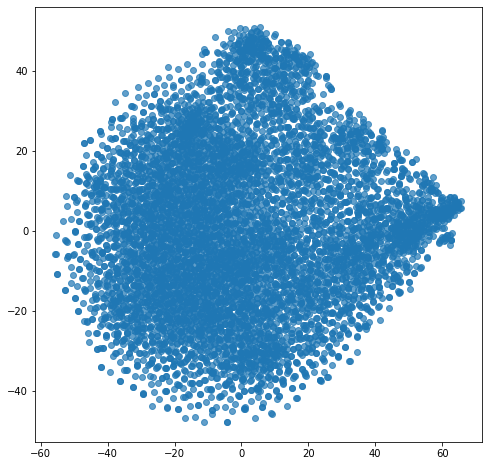

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()